# COMPSCI 389: Introduction to Machine Learning
# Nearest Neighbor Variants

In this notebook we present a few improved nearest neighbor algorithms.

**Note:** This notebook is described in the slides, `5.0 Nearest Neighbor Variants.pdf`. All of the important content within this notebook is in those slides, so you are not responsible for this notebook. However, you may reference this notebook to run the examples from the slides.

Recall from last time:

In [1]:
import pandas as pd
from sklearn.neighbors import KDTree
from sklearn.base import BaseEstimator
import numpy as np

class NearestNeighbor(BaseEstimator):
    def fit(self, X, y):
        # Convert X and y to NumPy arrays if they are DataFrames. This makes fit compatible with numpy arrays or DataFrames
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values

        # Store the training data and labels.
        self.X_data = X
        self.y_data = y
        
        # Create a KDTree for efficient nearest neighbor search
        self.tree = KDTree(X)

        return self

    def predict(self, X):
        # Convert X to a NumPy array if it's a DataFrame
        if isinstance(X, pd.DataFrame):
            X = X.values

        # We will iteratively load predictions, so it starts empty
        predictions = []
        
        # Loop over rows in the query
        for x in X:
            # Query the tree for the nearest neighbor
            dist, ind = self.tree.query([x], k=1)
            nearest_label = self.y_data[ind[0][0]]
            predictions.append(nearest_label)

        # Return the array of predictions we have created
        return np.array(predictions)

## Nearest Neighbors Properties

## Pros
- Very simple
- Sometimes all you need!
- Efficient. $O(\log(n))$ average case, $O(n)$ worst case.
    - Note: If you aren't familiar with this big-O notation, which is covered in COMPSCI 311, don't worry. You will not be tested on it.

## Cons
- Not always accurate, even with large amounts of data.

Consider the following case:

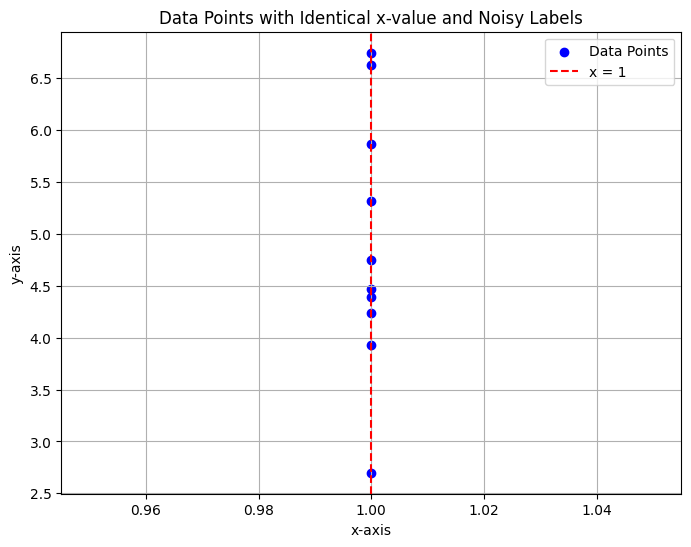

In [2]:
# This code creates an image of interest. The code is not worth studying, just running.
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)

# Generate sample data
x = np.ones(10)  # All x-values are 1
y = np.random.normal(5, 1, len(x))  # y-values are normally distributed around 5 with some noise

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', label='Data Points')
plt.axvline(x=1, color='red', linestyle='--', label='x = 1')

# Adding annotations and labels for clarity
plt.title("Data Points with Identical x-value and Noisy Labels")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Consider these 10 ten data points when the query is $x=1$. All of these points are zero distance from the query. Which one should be returned by nearest neighbor? Even as we get more and more data, our predictions given $x=1$ (in this case) will have high variance depending on which point we select.

**Question**: What should we do in this case?

**Answer**: Take the average of the labels (or perhaps the median).

So, we can update our algorithm to break ties by averaging the labels (in the regression setting). However, consider this case:

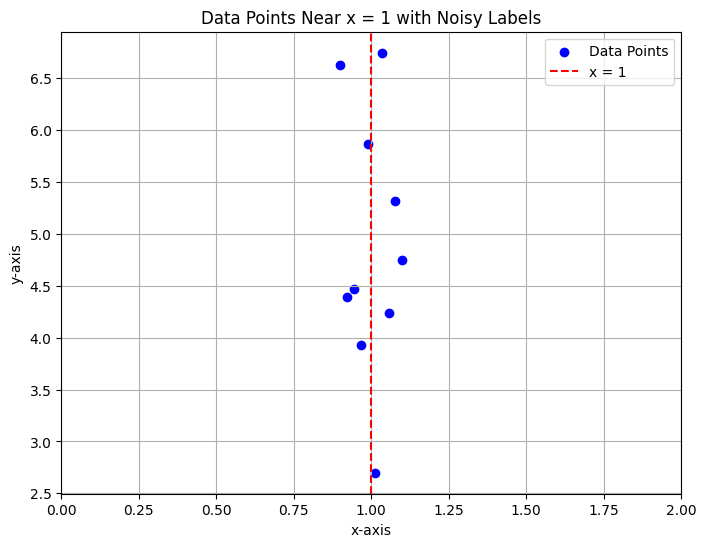

In [3]:
# This code creates an image of interest. The code is not worth studying, just running.
x = np.linspace(0.9, 1.1, 10)

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', label='Data Points')
plt.axvline(x=1, color='red', linestyle='--', label='x = 1')
plt.xlim(0, 2)

# Adding annotations and labels for clarity
plt.title("Data Points Near x = 1 with Noisy Labels")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Imagine that the blue points are just some of the nearby points, and that other points span the x-axis from -100 to 100. What should we do in this case? There is no tie, but there are many points with x-values close to $1.0$ (the query). 

## k-Nearest Neighbors

**Idea**: Average the labels of the $k$ nearest points, where $k$ is an integer hyperparameter.

Note: A **hyperparameter** of an ML algorithm is a variable, like $k$, that changes the behavior of the algorithm, and which is often set by the data scientist applying the algorithm.

This updated algorithm is called **k-Nearest Neighbor** and has the following pseudocode:

1. Find the $k$ inputs closest to the query.
2. Return the average of the labels for these $k$ closest inputs.

In [4]:
class KNearestNeighbors(BaseEstimator):
    # Add a constructor that stores the value of k (a hyperparameter)
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        # Convert X and y to NumPy arrays if they are DataFrames
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values

        # Store the training data and labels
        self.X_data = X
        self.y_data = y
        
        # Create a KDTree for efficient nearest neighbor search
        self.tree = KDTree(X)

        return self

    def predict(self, X):
        # Convert X to a NumPy array if it's a DataFrame
        if isinstance(X, pd.DataFrame):
            X = X.values

        # Query the tree for the k nearest neighbors for all points in X
        dist, ind = self.tree.query(X, k=self.k)

        # Return the average label for the nearest neighbors of each query
        return np.mean(self.y_data[ind], axis=1)

Let's compare the performance of k-NN to NN using the matrics that we discussed earlier:

In [5]:
def mean_squared_error(predictions, labels):
    return np.mean((predictions - labels) ** 2)

def root_mean_squared_error(predictions, labels):
    return np.sqrt(mean_squared_error(predictions, labels))

def mean_absolute_error(predictions, labels):
    return np.mean(np.abs(predictions - labels))

def r_squared(predictions, labels):
    ss_res = np.sum((labels - predictions) ** 2)        # ss_res is the "Sum of Squares of Residuals"
    ss_tot = np.sum((labels - np.mean(labels)) ** 2)    # ss_tot is the "Total Sum of Squares"
    return 1 - (ss_res / ss_tot)

In [6]:
from sklearn.model_selection import train_test_split

# Load the data set
df = pd.read_csv("data/GPA.csv", delimiter=',')

# We already loaded X and y, but do it again as a reminder
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split the data into training and testing sets (60% train, 40% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True)

In [7]:
# List of values of k to test
k_values = [1, 2, 3, 5, 10, 100, 1000, 5000]

# List to store the results. This will be a list of dictionaries
results_list = []

# Evaluate NN and k-NN models
for k in k_values:
    model = KNearestNeighbors(k=k)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    mse = mean_squared_error(predictions, y_test)
    rmse = root_mean_squared_error(predictions, y_test)
    mae = mean_absolute_error(predictions, y_test)
    r2 = r_squared(predictions, y_test)

    # Create a dictionary with the relevant variables from this value of k, and add it to results_list.
    results_list.append({'k': k, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R^2': r2})

# Create DataFrame from the list of results. Each dictionary in the list becomes a row in the DataFrame and the keys of the dictionaries become the column headers.
results = pd.DataFrame(results_list)

# Print the results
display(results)

,k,MSE,RMSE,MAE,R^2
0,1,1.152084,1.073352,0.823743,-0.687769
1,2,0.853430,0.923813,0.713553,-0.250249
2,3,0.764468,0.874339,0.678162,-0.119923
3,5,0.688330,0.829657,0.644951,-0.008384
4,10,0.631001,0.794356,0.620237,0.075602
5,100,0.579404,0.761186,0.596919,0.151190
6,1000,0.581676,0.762677,0.600227,0.147861
7,5000,0.600544,0.774947,0.616670,0.120221


To make this easier on the eyes, let's highlight the minimum values in bold. The below requires the `jinja2` library:
> pip install jinja2

In [8]:
# Function to apply bold style to the minimum value in each column, except for R^2 where we highlight the maximum
def highlight_extreme(s):
    if s.name == 'R^2':
        is_extreme = s == s.max()
    else:
        is_extreme = s == s.min()
    return ['font-weight: bold' if v else '' for v in is_extreme]

# Apply the styling
styled_results = results.style.apply(highlight_extreme, subset=['MSE', 'RMSE', 'MAE', 'R^2'])

# Display the styled DataFrame
styled_results

,k,MSE,RMSE,MAE,R^2
0,1,1.152084,1.073352,0.823743,-0.687769
1,2,0.853430,0.923813,0.713553,-0.250249
2,3,0.764468,0.874339,0.678162,-0.119923
3,5,0.688330,0.829657,0.644951,-0.008384
4,10,0.631001,0.794356,0.620237,0.075602
5,100,0.579404,0.761186,0.596919,0.151190
6,1000,0.581676,0.762677,0.600227,0.147861
7,5000,0.600544,0.774947,0.616670,0.120221


## Weighted k-Nearest Neighbors

What if, when running k-NN some of the k-nearest points are very close to the query point and others are actually quite far away? Our method weights these points equally when making its prediction.

**Idea**: Assign different weights to each of the k neighbors based on their distance from the query point.

This ensures that closer neighbors have a bigger influence on the prediction than neighbors that are farther away.

Let $(x^\text{NN}_i, y^\text{NN}_i)$ be the $i^\text{th}$ nearest neighbor.

Let $w_i$ be the weight associated with the point $(x^\text{NN}_i, y^\text{NN}_i)$. We will consider only non-negative weights, i.e., $w_i \geq 0$. Soon we will describe how to compute $w_i$.

The weighted k-NN prediction is then:
$$
\hat y = \frac{\sum_{i=1}^k w_i \, y^\text{NN}_i}{\sum_{j=1}^k w_j}
$$
which is equivalent to
$$
\hat y = \sum_{i=1}^k \frac{w_i}{\sum_{j=1}^k w_j} \, y^\text{NN}_i.
$$

To see why we divide by the sum of the weights, consider the case where $k=2$ and $w_1=w_2=1$. In this case, if we didn't divide by the sum of the weights the prediction would be $y_1^\text{NN} + y_2^\text{NN}$, which will be roughly two times too big. Dividing by the sum of the weights makes the weights sum to one, and results in a **weighted average** of the labels.

### Weighting Options

There are several methods to assign weights in weighted k-NN. 

**Question**: Would it be reasonable to use $w_i=\operatorname{dist}(x_i^\text{NN}, x_\text{query})$?

**Answer**: No, this would place larger weights on points farther from the query.

One option would be to use the inverse of the distance as the weight:
$$
w_i = \frac{1}{\operatorname{dist}(x_i^\text{NN}, x_\text{query})}.
$$
However, we might want the weight to decrease faster for points that are farther away. Consider the following bell-curve shape mapping distances to weights:

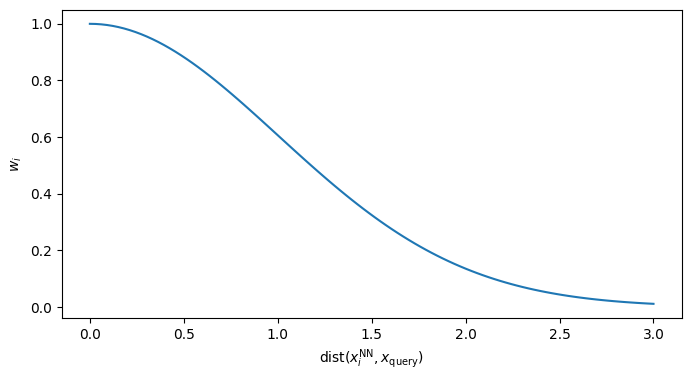

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Gaussian Kernel Function
def gaussian_kernel(distance, sigma=1.0):
    return np.exp(- (distance ** 2) / (2 * sigma ** 2))

# Generate distance values from 0 to 3
distances = np.linspace(0, 3, 100)

# Compute weights using the Gaussian kernel
weights = gaussian_kernel(distances)

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(distances, weights)
plt.xlabel(r'dist$(x_i^{\text{NN}}, x_{\text{query}})$') # Use raw string so we don't have to escape the backslashes in LaTeX
plt.ylabel(r'$w_i$')
plt.show()


This function is called the **Gaussian kernel**. It is the (re-scaled) probability density function of a normal distribution:
$$
f(x)=\frac{1}{\sigma \sqrt{2\pi}}e^{-\frac{(x-\mu)^2}{2\sigma^2}},
$$
with mean $\mu=0$ and standard deviation $\sigma=1$.

Because we will divide all weights by the sum of the weights, scaling each weight by the same constant has no impact on the final weighting. So, we can drop the $\frac{1}{\sigma \sqrt{2\pi}}$ term and write the Gaussian kernel as:
$$
e^{-\frac{(x-\mu)^2}{2\sigma^2}}.
$$
We will apply this with $\mu=0$ and with $x$ corresponding to the distance between the query and point, so we can write this as:
$$
e^{-\frac{\operatorname{dist}(x_i^\text{NN}, x_\text{query})^2}{2\sigma^2}}.
$$

Cleaning this up, let:
$$
d_i = \operatorname{dist}(x_i^\text{NN}, x_\text{query}),
$$
and
$$
w_i = e^{-\frac{d_i^2}{2\sigma^2}}.
$$

We can then plug this weight into the weighted k-NN prediction equation:
$$
\hat y = \frac{\sum_{i=1}^k w_i \, y^\text{NN}_i}{\sum_{i=1}^k w_i}.
$$

Before we experiment with this new NN variant, let's think more about what $\sigma$ (another hyperparameter) does.

**Question**: What is the impact of a bigger value for $\sigma$?

**Answer**: A larger value of sigma makes the weight curve wider, placing larger weights on points that are farther away. A smaller value of sigma makes the weight curve tighter, placing more emphasis on points that are closer. We can see this in the following plot:

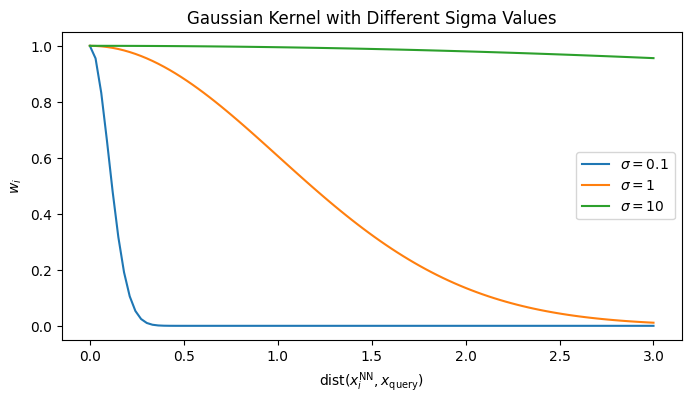

In [10]:
# Plotting for different sigma values
plt.figure(figsize=(8, 4))

for sigma in [0.1, 1, 10]:
    weights = gaussian_kernel(distances, sigma)
    plt.plot(distances, weights, label=rf'$\sigma = {sigma}$')  # LaTeX formatting for sigma


plt.xlabel(r'dist$(x_i^{\text{NN}}, x_{\text{query}})$') # Use raw string for LaTeX
plt.ylabel(r'$w_i$')
plt.title('Gaussian Kernel with Different Sigma Values')
plt.legend()
plt.show()


Ok, let's code up the weighted k-NN algorithm!

In [11]:
import pandas as pd
from sklearn.neighbors import KDTree
from sklearn.base import BaseEstimator
import numpy as np

class WeightedKNearestNeighbors(BaseEstimator):
    # Add a constructor that stores the value of k and sigma (hyperparameters)
    def __init__(self, k=3, sigma=1.0):
        self.k = k
        self.sigma = sigma

    def fit(self, X, y):
        # Convert X and y to NumPy arrays if they are DataFrames
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values

        # Store the training data and labels
        self.X_data = X
        self.y_data = y
        
        # Create a KDTree for efficient nearest neighbor search
        self.tree = KDTree(X)

        return self

    def gaussian_kernel(self, distance):
        # Gaussian kernel function
        return np.exp(- (distance ** 2) / (2 * self.sigma ** 2))

    def predict(self, X):
        # Convert X to a NumPy array if it's a DataFrame
        if isinstance(X, pd.DataFrame):
            X = X.values

        # We will iteratively load predictions, so it starts empty
        predictions = []
        
        # Loop over rows in the query
        for x in X:
            # Query the tree for the k nearest neighbors
            dist, ind = self.tree.query([x], k=self.k)

            # Calculate weights using the Gaussian kernel
            weights = self.gaussian_kernel(dist[0])

            # Check if weights sum to zero. This happens when all points are very far, giving weights that round to zero, causing divison by zero later. In this case, revert to un-weighted (all weights are one).
            if np.sum(weights) == 0:
                # If weights sum to zero, assign equal weight to all neighbors
                weights = np.ones_like(weights)

            # Weighted average of the labels of the k nearest neighbors
            weighted_avg_label = np.average(self.y_data[ind[0]], weights=weights)
            predictions.append(weighted_avg_label)

        # Return the array of predictions we have created
        return np.array(predictions)

Let's add this to our comparison of methods:

In [12]:
# Model parameters to test
parameters = [
    {"k": 1, "sigma": None},    # Standard k-NN
    {"k": 100, "sigma": None},  # Standard k-NN
    {"k": 100, "sigma": 100},
    {"k": 200, "sigma": 100},
    {"k": 300, "sigma": 100},
    {"k": 400, "sigma": 100},
    {"k": 500, "sigma": 100}
]

# Dictionary to store results
results = []

# Training and evaluating each model
for param in parameters:
    # Determine which model to use. Notice that we can use k-NN for NN by setting k=1
    if param["sigma"] is None:
        model = KNearestNeighbors(k=param["k"])
    else:
        model = WeightedKNearestNeighbors(k=param["k"], sigma=param["sigma"])

    # Train the model and get the predictions on the test set
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    mse = mean_squared_error(predictions, y_test)
    rmse = root_mean_squared_error(predictions, y_test)
    mae = mean_absolute_error(predictions, y_test)
    r2 = r_squared(predictions, y_test)

    results.append({"Model": f"k-NN k={param['k']} sigma={param['sigma']}", 
                    "MSE": mse, "RMSE": rmse, "MAE": mae, "R^2": r2})

# Creating DataFrame for results
results_df = pd.DataFrame(results)

# Finding the best (minimum or maximum) values for each metric
best_metrics = {
    "MSE": results_df['MSE'].idxmin(),
    "RMSE": results_df['RMSE'].idxmin(),
    "MAE": results_df['MAE'].idxmin(),
    "R^2": results_df['R^2'].idxmax()
}

# Highlighting the best values in the DataFrame
def highlight_best(row, best_metrics):
    return ['font-weight: bold' if (col in best_metrics and row.name == best_metrics[col]) else '' for col in row.index]

# Apply the highlighting
styled_results = results_df.style.apply(highlight_best, best_metrics=best_metrics, axis=1)
styled_results

,Model,MSE,RMSE,MAE,R^2
0,k-NN k=1 sigma=None,1.152084,1.073352,0.823743,-0.687769
1,k-NN k=100 sigma=None,0.579404,0.761186,0.596919,0.151190
2,k-NN k=100 sigma=100,0.579572,0.761297,0.596952,0.150943
3,k-NN k=200 sigma=100,0.577554,0.759970,0.596220,0.153901
4,k-NN k=300 sigma=100,0.577443,0.759897,0.596408,0.154062
5,k-NN k=400 sigma=100,0.577620,0.760013,0.596670,0.153804
6,k-NN k=500 sigma=100,0.578077,0.760314,0.597044,0.153135


In this case, it doesn't make a big difference. We will re-visit this later, seeing more significant improvements for other data sets.

**Question**: How can the nearest neighbor algorithms be extended to the classification setting?

**Answer (k-NN)**: The most common method is to use a majority vote among the k nearest neighbors. That is, whichever label is most common among the nearest neighbors is selected. 

**Answer (weighted k-NN)**: Each neighbor's vote is weighted in the vote.

# Tuning Hyperparameters

Let we will discuss the tuning of hyperparameters more. For now, notice that this is often more of an art than a science. Over time, you become more familiar with how different parameters change the behavior of algorithms and learn to guess changes to hyperparameters that could be more effective.

In this case, let's run a **grid search** over values of k and $\sigma$ to see which are most effective.

A **grid search** for hyperparameters involves training an evaluating a model exhaustively over a specified range of hyperparameter values, with the aim of identifying the combination of parameters that results in the best performance. This process involves creating and testing every possible combination of the provided parameter values.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import os

# Path to the cache file
cache_file = 'cache/Lecture_5/hyperparamSearch.pkl'
re_run = False  # Set to True to force re-running the grid search

# Check if cache file exists and re_run is False
if not os.path.exists(cache_file) or re_run:
    # Define the ranges for k and sigma
    k_values = [k for k in range(100, 1100, 100)]
    sigma_values = [20, 50, 75, 100, 200, 400, 600]

    # Initialize matrix to store R^2 values
    r2_values = np.zeros((len(k_values), len(sigma_values)))

    # Grid search
    for i, k in enumerate(k_values):
        for j, sigma in enumerate(sigma_values):
            model = WeightedKNearestNeighbors(k=k, sigma=sigma)
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)

            # Compute R^2 value
            r2 = r_squared(predictions, y_test)
            r2_values[i, j] = r2
            
     # Save the results to a pickle file
    with open(cache_file, 'wb') as f:
        pickle.dump({'r2_values': r2_values, 'k_values': k_values, 'sigma_values': sigma_values}, f)
else:
    # Load the results from the pickle file
    with open(cache_file, 'rb') as f:
        data = pickle.load(f)
        r2_values = data['r2_values']
        k_values = data['k_values']
        sigma_values = data['sigma_values']

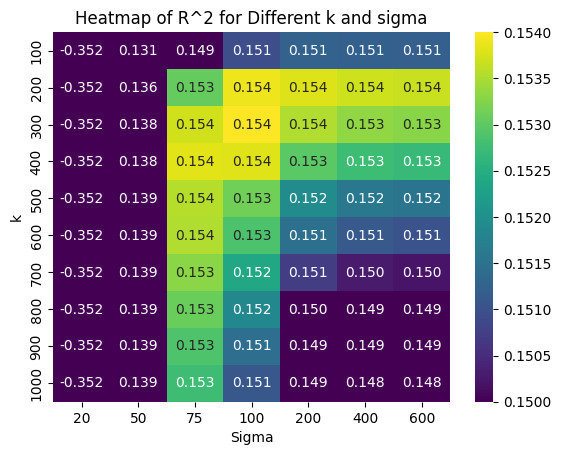

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming r2_values, sigma_values, and k_values are defined

fig, ax = plt.subplots()
# Create a heatmap with specified value range
sns.heatmap(r2_values, annot=True, fmt=".3f", cmap='viridis', 
            xticklabels=sigma_values, yticklabels=k_values, ax=ax, 
            vmin=0.15, vmax=0.154)

# Set axis labels
ax.set_xlabel('Sigma')
ax.set_ylabel('k')
ax.set_title('Heatmap of R^2 for Different k and sigma')

plt.show()


**Question**: Why do you think a value of k around 200 is particularly effective for this problem?

**Question**: Why do you think changing sigma makes little difference when it is large?

As you work with each ML algorithm, you'll start to get a sense for how to set the different hyperparameters, and how to tune them manually.